In [1]:
import os
import io
import json
import pathlib
import statistics
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import PIL.Image

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import matplotlib.pyplot as plt

#print GPU availability
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

Num GPUs Available: 2


In [2]:
model_name = 'alpha-score'
output_dir = f'{os.getcwd()}/model_output/{model_name}'
data_dir = os.path.join(os.getcwd(), '..' , f'data/{model_name}')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load Data from Disk

In [3]:
#Load the data frame... nothing that special here
raw_df = pd.read_json(os.path.join(data_dir,'downloads/master_cleaned.json'))
    
transposed_df = raw_df.T
transposed_df.head()

,thumbnail_url,gender,nationality,location,birthday,description,name,thumbnail_file,date,num_followers,handle,obj_birthday
00100011,https://d32dm0rphc51dk.cloudfront.net/77LaVwWd...,nonbinary,USA,,,NA,NA,NA,2020-08-01T00:00:00Z,0,00100011,None
0331_studio,https://d32dm0rphc51dk.cloudfront.net/iZ_5gDno...,male,Russian,"Moscow, Russia",,NA,NA,NA,2020-08-01T00:00:00Z,1879,0331_studio,None
06d_atelier,https://d32dm0rphc51dk.cloudfront.net/YUNtYH9f...,n/a,Italian,"London, UK",,NA,NA,NA,2020-07-01T03:00:00Z,2320,06d_atelier,None
11.11.1,https://d32dm0rphc51dk.cloudfront.net/jS7hjyXq...,None,Swedish Icelandic Finnish,"Reykjavík, Iceland",,NA,NA,NA,2020-08-01T00:00:00Z,3688,11.11.1,None
rola_084,https://d32dm0rphc51dk.cloudfront.net/UP6KjVd-...,None,,,,NA,NA,NA,None,None,None,None


In [4]:
image_df = transposed_df[['thumbnail_file','num_followers']]
image_df = image_df[~image_df['thumbnail_file'].str.contains('NA', na=False)]
image_df.fillna(value=0, inplace=True)
image_df = image_df[image_df["num_followers"] > 2000]
print(len(image_df))
image_df.head()

9619


,thumbnail_file,num_followers
pioabad,data/alpha-score/downloads/thumbs/pioabad.jpg,2142
10_sketch,data/alpha-score/downloads/thumbs/10_sketch.jpg,3844
1111rob,data/alpha-score/downloads/thumbs/1111rob.jpg,32880
1390photo,data/alpha-score/downloads/thumbs/1390photo.jpg,7356
18thstreetarts,data/alpha-score/downloads/thumbs/18thstreetar...,6216


# Setup Labels (Followers)


In [5]:
y = list(image_df.num_followers)

#TODO cleverly reshape y? better than this? multiple classes/categories?
#Reshape y to "above or below average" followers
y = [1 if f > 10000 else 0 for f in y]

print(f'{len(y)} artists with {sum(y)/len(y)} tag ratio')

9619 artists with 0.4175070173614721 tag ratio


# Setup Images

34771 thumbnail images


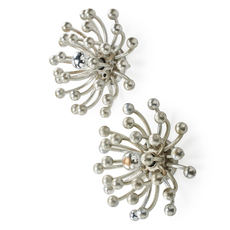

In [6]:
image_count = len(list(glob.glob(f'{data_dir}/downloads/thumbs/*.jpg')))
print(f'{image_count} thumbnail images')

#View a single image (as a test)
PIL.Image.open(os.path.join(os.getcwd(), "..", str(image_df.thumbnail_file[100])))

In [7]:
batch_size = 32
img_height = 200
img_width = 200

images = []
for image_path in list(image_df.thumbnail_file):
    full_path = os.path.join(os.getcwd(),"..",image_path)
    image = tf.keras.preprocessing.image.load_img(full_path,color_mode='rgb',target_size=(img_height,img_width))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    images.append(input_arr)

x = images

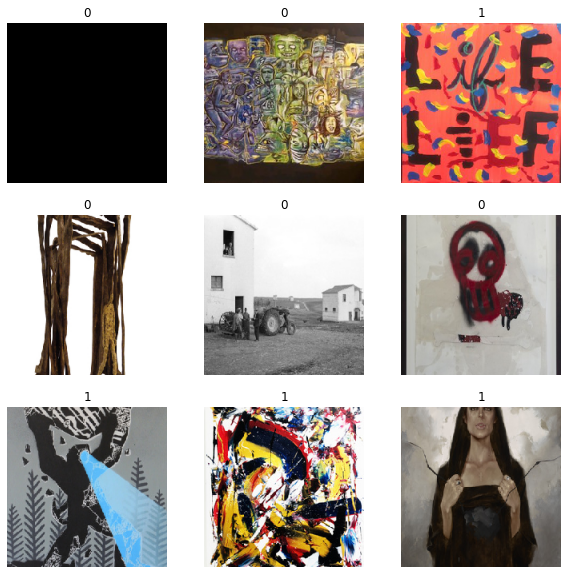

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].astype("uint8"))
    plt.title(y[i])
    plt.axis("off")

# Model and Train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [10]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='tanh'),
  tf.keras.layers.Dense(128, activation='tanh'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
                       
    
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")


In [11]:
model.fit(np.array(X_train), np.array(y_train),
          batch_size=64,
          validation_data=(np.array(X_test),np.array(y_test)),
          epochs=10,
          callbacks=[modelcheckpoint])

Epoch 1/10
136/136 [==============================] - 7s 53ms/step - loss: 0.7017 - accuracy: 0.5341 - val_loss: 0.6945 - val_accuracy: 0.5572
Epoch 2/10
136/136 [==============================] - 7s 50ms/step - loss: 0.6879 - accuracy: 0.5620 - val_loss: 0.7161 - val_accuracy: 0.5624
Epoch 3/10
136/136 [==============================] - 7s 51ms/step - loss: 0.6897 - accuracy: 0.5645 - val_loss: 0.6841 - val_accuracy: 0.5655
Epoch 4/10
136/136 [==============================] - 7s 51ms/step - loss: 0.6853 - accuracy: 0.5703 - val_loss: 0.6866 - val_accuracy: 0.5478
Epoch 5/10
136/136 [==============================] - 7s 53ms/step - loss: 0.6865 - accuracy: 0.5653 - val_loss: 0.6933 - val_accuracy: 0.5800
Epoch 6/10
136/136 [==============================] - 7s 51ms/step - loss: 0.6874 - accuracy: 0.5616 - val_loss: 0.6856 - val_accuracy: 0.5759
Epoch 7/10
136/136 [==============================] - 7s 52ms/step - loss: 0.6836 - accuracy: 0.5713 - val_loss: 0.6877 - val_accuracy: 0.5780

In [12]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 
print(f'Test Score: {score[0]} Test Accuracy:, {score[1]}')

31/31 [==============================] - 0s 11ms/step - loss: 0.6835 - accuracy: 0.5665
Test Score: 0.6834844350814819 Test Accuracy:, 0.5665280818939209


# Load Weights, Test Model and Save

In [13]:
model.load_weights(output_dir+"/weights.05.hdf5") # NOT zero-indexed

0.40083483


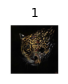

In [134]:
from random import randrange
i=randrange(len(y))

full_path = os.path.abspath(os.path.join(os.getcwd(), 
    "..", 
    list(image_df.thumbnail_file)[i]))
image = tf.keras.preprocessing.image.load_img(full_path,color_mode='rgb',target_size=(img_height,img_width))
input_arr = tf.keras.preprocessing.image.img_to_array(image)

plt.figure(figsize=(1, 1))
plt.imshow(input_arr.astype("uint8"))
plt.title(y[i])
plt.axis("off")

pred_followers = model.predict(np.array([input_arr]))
print(pred_followers[0][0])

In [135]:
model.save(output_dir+'/model_v001')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tf/train/model_output/alpha-score/model_v001/assets
